In [6]:
qiskit.__version__

'1.0.0'

In [14]:
# Initialisation
import numpy as np

from qiskit_ibm_provider import IBMProvider
#from qiskit_ibm_provider import least_busy, IBMQ, BasicAer
from qiskit import QuantumCircuit, transpile

provider = IBMProvider()
from qiskit.visualization import plot_histogram

In [15]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 2024

In [26]:
features = data.data
labels = data.target

In [22]:
df = pd.DataFrame(features, columns=data.feature_names)
df['class'] = [data.target_names[label] for label in labels]

In [40]:
feature_names = data.feature_names
feature_means = feature_names[:10]

In [45]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Load the Breast Cancer dataset
data = load_breast_cancer()

# Select only the mean features (the first 10 features)
feature_names = data.feature_names[:10]
X_means = data.data[:, :10]  # Selecting only the columns for mean features

# Initialize the StandardScaler and scale the mean features
scaler = StandardScaler()
X_means_scaled = scaler.fit_transform(X_means)

# Split the dataset into training and testing sets
X_train_means, X_test_means, y_train, y_test = train_test_split(X_means_scaled, data.target, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier on the mean features
rf_classifier_means = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_means.fit(X_train_means, y_train)

# Feature importance from the Random Forest model based on mean features
feature_importances_means = rf_classifier_means.feature_importances_
print("Feature importances (mean features) from Random Forest Classifier:")
for name, importance in zip(feature_names, feature_importances_means):
    print(f"{name}: {importance:.4f}")

# Evaluate the classifier on the mean features
rf_accuracy_means = rf_classifier_means.score(X_test_means, y_test)
print(f"\nRandom Forest Test Accuracy (mean features): {rf_accuracy_means:.4f}")


Feature importances (mean features) from Random Forest Classifier:
mean radius: 0.1262
mean texture: 0.0664
mean perimeter: 0.1440
mean area: 0.1079
mean smoothness: 0.0284
mean compactness: 0.0468
mean concavity: 0.1405
mean concave points: 0.3017
mean symmetry: 0.0194
mean fractal dimension: 0.0188

Random Forest Test Accuracy (mean features): 0.9474


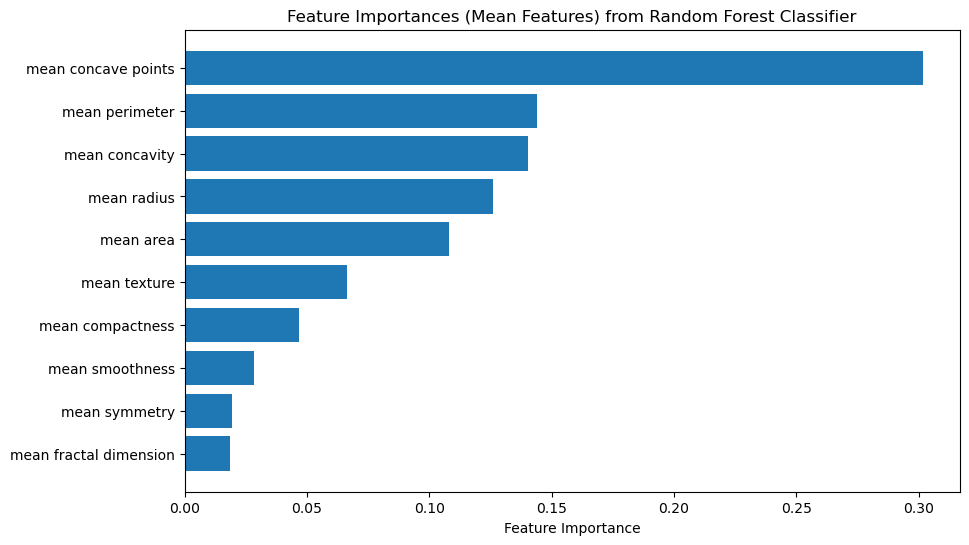

In [46]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                 'mean smoothness', 'mean compactness', 'mean concavity',
                 'mean concave points', 'mean symmetry', 'mean fractal dimension'] 

# Sort the features by importance
sorted_idx = np.argsort(feature_importances_means)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importances = [feature_importances_means[i] for i in sorted_idx]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Mean Features) from Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


# Feature Importance

To infer feature importance from the quanum models I will repeat QNN networks, emiting the feature of interest and observing the change in the objective function of the model.

In [73]:
num_features

10

In [75]:
from qiskit.circuit.library import ZZFeatureMap

num_features = 10

feature_map = ZZFeatureMap(feature_dimension=num_features, reps = 1)
#feature_map.decompose().draw('mpl', fold=20)

In [78]:
qc = QNNCircuit(feature_map=feature_map)

In [79]:
estimator_qnn = EstimatorQNN(circuit = qc)

In [96]:
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[-0.03064943]])

In [80]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [81]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

In [88]:
X = X_means

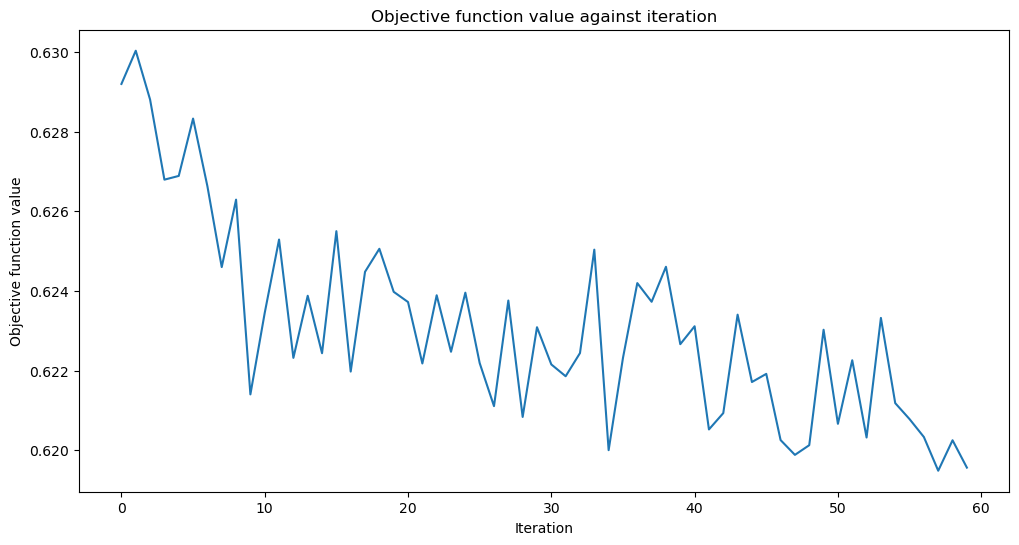

0.36731107205623903

In [97]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

In [94]:
 estimator_classifier.weights

array([ 0.70379903,  1.14143664,  1.37193049,  0.87262701,  1.98955534,
        1.13926374,  1.14890529,  0.12705674,  1.40903953,  0.11969461,
        0.50260791,  0.59444134,  0.04495693,  0.54051631, -0.0527989 ,
        0.45113709,  0.91156696,  0.71933083,  0.60355012,  0.26876615,
        0.18740901,  1.11310847,  0.25192446,  1.54002548,  0.19396125,
        1.28145462,  0.74247266,  1.27496997,  0.21309867,  0.03871983,
        0.44228347,  0.22508701,  0.78645441,  1.3066803 ,  0.71725974,
        0.38488969,  0.37710498,  0.85257248,  0.83329153,  0.00311727])

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
import numpy as np

# Load the dataset
data = load_breast_cancer()
X = data.data[:, :10]  # Using only the mean features as mentioned
y = data.target

# Normalize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to omit a feature and split the data
def prepare_datasets(feature_index, X, y, test_size=0.2, random_state=42):
    """
    Omit a specified feature, then split the data into training and testing sets.
    
    Parameters:
    - feature_index: Index of the feature to omit. If None, no feature is omitted.
    - X: Input features array.
    - y: Target array.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Controls the shuffling applied to the data before applying the split.
    
    Returns:
    - X_train, X_test, y_train, y_test: Split datasets.
    """
    if feature_index is not None:
        X_modified = np.delete(X, feature_index, axis=1)  # Omit the specified feature
    else:
        X_modified = X  # Use the dataset as is if no feature is omitted
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_modified, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

# Example usage
feature_index = 0  # Index of the feature to omit
X_train, X_test, y_train, y_test = prepare_datasets(feature_index, X_scaled, y)